# CS 123A Project: Building a protein secondary structure predictor
Rachel Stanik, Phuong Tran


# Step 1: Importing libraries

In [196]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Step 2: Reading in the Data and Parsing the Data

In [197]:
file = open("dataset.txt", "r")

## Parse the data

Data must be in following format: <br>
'> Protein sequence name' <br>
'\n' <br>
'< amino acid sequence>' <br>
'\n' <br>
'< secondary structure>' <br>
'\n' <br>

In [198]:
def parse_data(file, sequences, structures):
    lines = file.readlines()
    new_seq = False
    new_struct = False
    full_seq = ""
    full_struct = ""
    
    #Parse the text
    for line in lines:
        #new protein sequence and structure
        if ">" in line:
            new_seq = True
            new_struct = False
            full_seq = ""
            full_struct = ""
            #print(line) # for debugging
            
        #end of the amino acid sequence
        elif new_seq and line == "\n":
            new_seq = False
            new_struct = True
            sequences.append(full_seq)
            #print(full_seq) #for debugging
            
        elif new_seq:
            line = line.strip()
            full_seq += line
            
        #end of secondary structure
        elif new_struct and line == "\n":
            structures.append(full_struct)
            #print(full_struct) #for debugging
            #print() #for debugging
            new_seq = False
            new_struct = False
            
        elif new_struct:
            line = line.strip()
            full_struct += line
    
sequences = []
structures = []
parse_data(file, sequences, structures)

### Functions for debugging 
Ensure that the length of the amino acid sequence matches the length of the structure sequence

In [201]:
# For Debugging
def validate_lengths():
    for i in range(0, len(sequences)):
        print("\nNEW SEQUENCE")
        print(sequences[i])
        print("Length of sequence {}: {}, Length of the structure: {}".format(i, len(sequences[i]), len(structures[i])))
        print(len(sequences[i]) == len(structures[i]))
        
print("Read in {} amino acid sequences.".format(len(sequences)))
print("Read in {} secondary structure sequences.".format(len(structures)))

validate_lengths()

Read in 13 amino acid sequences.
Read in 13 secondary structure sequences.

NEW SEQUENCE
MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQKKGPSQCPLCKNDITKRSLQESTRFSQLVEELLKIICAFQLDTGLEYANSYNFAKKGK
Length of sequence 0: 112, Length of the structure: 112
True

NEW SEQUENCE
MAGEEVKEIDEFEELGFEPATEETPKKKKKEKIIRSIEDLPGVGPATAEKLREAGYDTLEAIAVASPIELKEVAGISEGTALKIIQAARKAANLGTFMRADEYLKKRATIGRISTGSKSLDKLLGGGIETQAITEVFGEFGSGKTQLAHTLAVMVQLPPEEGGLNGSVIWIDTENTFRPERIREIAQNRGLDPDEVLKHIYVARAFNSNHQMLLVQQAEDKIKELLNTDRPVKLLIVDSLTSHFRSEYIGRGALAERQQKLAKHLADLHRLANLYDIAVFVTNQVQARPDAFFGDPTRPIGGHILAHSATLRVYLRKGKGGKRIARLIDAPHLPEGEAVFSITEKGIED
Length of sequence 1: 349, Length of the structure: 349
True

NEW SEQUENCE
MSEKKQPVDLGLLEEDDEFEEFPAEDWAGLDEDEDAHVWEDNWDDDNVEDDFSNQLRAELEKHGYKMETS
Length of sequence 2: 70, Length of the structure: 70
True

NEW SEQUENCE
MSEKKQPVDLGLLEEDDEFEEFPAEDWAGLDEDEDAHVWEDNWDDDNVEDDFSNQLRAELEKHGYKMETS
Length of sequence 3: 70, Length of the structure: 70
True

NEW SEQUENCE
KADLGPISLN

# Step 3: Data Preprocessing

## Process the amino acid sequence
### Perform one-hot encoding
Referenced: https://dmnfarrell.github.io/bioinformatics/mhclearning for encoding

In [203]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def one_hot_encode(seq):
    #amino acids not in the sequence
    missing_amino_acids = list(set(codes) - set(seq))
    seq_df = pd.DataFrame(list(seq)) 
    #Create a df with only 0's and the 'missing' amino acids
    index = pd.DataFrame(np.zeros((len(seq),len(missing_amino_acids)),dtype=int),columns=missing_amino_acids) 
    df = seq_df[0].str.get_dummies(sep=',')
    #join the df with the zero df on their indices (position of the amino acid)
    df = df.join(index)
    df = df.sort_index(axis=1)
    return df

#Create a list of dataframes
encoded_sequences = []
for sequence in sequences:
    encoded_sequences.append(one_hot_encode(sequence))


### Example of the result after encoding
An example dataframe for the first sequence

In [204]:
print('Encoded sequence for: \n{}\n'.format(sequences[0]))
print('''The index represents the sequence position.
A value of "1" indicates the amino acid in that position.''')
encoded_sequences[0]

Encoded sequence for: 
MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQKKGPSQCPLCKNDITKRSLQESTRFSQLVEELLKIICAFQLDTGLEYANSYNFAKKGK

The index represents the sequence position.
A value of "1" indicates the amino acid in that position.


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
109,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
110,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Combine all encoded amino acid sequences into one Dataframe

In [205]:
seq_df = pd.DataFrame(columns=codes)
for seq in encoded_sequences:
    seq_df = pd.concat([seq_df, seq])
seq_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
101,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Process the target variable (secondary structure)
### Convert from Category (-,E,H) to Numerical Values

In [206]:
struct_df = pd.DataFrame(columns=['struct'])
for struct in structures:
    struct_df = pd.concat([struct_df, pd.DataFrame(list(struct), columns=['struct'])])

#convert ['-' 'H' 'E'] into numerical values
struct_df['struct'] = struct_df['struct'].astype('category')
legend = dict(enumerate(struct_df['struct'].cat.categories))
print(legend)
struct_df['struct'] = struct_df['struct'].cat.codes
struct_df

{0: '-', 1: 'E', 2: 'H'}


,struct
0,0
1,0
2,2
3,2
4,2
...,...
99,1
100,1
101,1
102,1


## Validate the number of rows match in both dataframes

In [208]:
len(seq_df.index) == len(struct_df.index)

True

# Step 4: Model Building

## Train-Test Split

In [177]:
#70-30 Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(seq_df, struct_df, test_size=0.3, random_state=1)
print('x_train', x_train.shape, '\ny_train', y_train.shape, '\nx_test', x_test.shape, '\ny_test', y_test.shape)

x_train (1516, 20) 
y_train (1516, 1) 
x_test (651, 20) 
y_test (651, 1)


## Build Neural Network

In [178]:
model = MLPClassifier()
model.fit(x_train, y_train.values.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

# Step 5: Model Evaluation

In [185]:
preds = model.predict(x_test)
print('Accuracy for test set= ', accuracy_score(y_test, preds))
print('Accuracy for training data= ', accuracy_score(y_train, model.predict(x_train)))

Accuracy for test set=  0.5084485407066052
Accuracy for training data=  0.5441952506596306


## Confusion Matrices
Followed: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix as a guide to making it pretty

In [186]:
#needed for using matplotlib in jupyter notebook
%matplotlib inline

def create_cm(title, cm):
    #'-' = Coil, 'E' = Sheet, 'H' = Helix
    df_cm = pd.DataFrame(array, ['Coil','Sheet','Helix'],
                      ['Coil', 'Sheet', 'Helix'])
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")

    # fix for mpl bug that cuts off top/bottom of seaborn viz 
    # link: https://github.com/mwaskom/seaborn/issues/1773
    b, t = plt.ylim() # the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.show()

### For Test Set

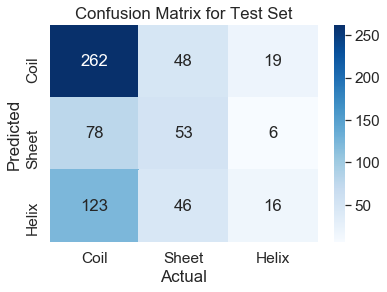

In [187]:
array = confusion_matrix(y_test, preds)
create_cm("Confusion Matrix for Test Set", array)

### For Training Set

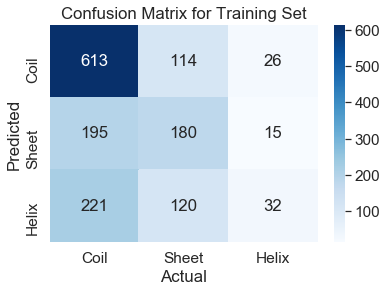

In [188]:
array= confusion_matrix(y_train, model.predict(x_train))
create_cm("Confusion Matrix for Training Set", array)